In [2]:
from PIL import Image, ImageDraw
import numpy as np
import random

In [3]:
class gameObj():
    def __init__(self,name,position,reward,has_ball):
        self.x = position[0]
        self.y = position[1]
        self.reward = reward
        self.name = name
        self.has_ball = has_ball
    def changeObj(self,name,position,reward):
        self.x = position[0]
        self.y = position[1]
        self.reward = reward
        self.name = name
    def getName(self):
        return self.name
    def getCoor(self):
        return(self.x,self.y)
    def printCoor(self):
        return str(self.x) + ", "+ str(self.y)
    def removeBall(self):
        self.has_ball=False
    def receiveBall(self):
         self.has_ball=True   
    #def drawSelf(self):
    #    if name is "Goal":
    #        self.draw_info= 
    ##    elif name is "Player":
     #       self.draw_info= 
     #   elif name is "Enemy":
     #       self.draw_info=
     #   else:
     #       self.draw_info=
        
#class gamePlayer(gameObj):
#    def __init__(self,name,position,reward,has_ball):
#        super().__init__(name,position,reward)
##        self.has_ball=has_ball
 #   def removeBall(self):
 #       self.has_ball=False
 #   def receiveBall(self):
 #       self.has_ball=True

In [190]:
class gameEnv():
    def __init__(self,image_size,user_bots):
        #Initialization of the grid length, and width which will be used to keep track of game state
        self.grid_length = (user_bots*2)
        self.grid_width = user_bots
        #Image size, biffer will be used for drawing on Canvas with draw object
        self.image_size=image_size
        self.x_buffer=image_size/user_bots
        self.y_buffer=image_size/(user_bots * 2)
        self.canvas=Image.new('RGB',(self.image_size,self.image_size),(155,155,155))
        self.draw=ImageDraw.Draw(self.canvas)
        #Used at the start of the game and to reset when game is finished
        self.reset()
        
    def reset(self):
        #This sets the object grid, which contains the name, coordinates,and reward of each game object (enemy, player, goal, or space)
        self.object_grid=[[gameObj("Space",[j,i],0,False) for j in range(self.grid_width)] for i in range(self.grid_length)]
        self.setupGoal()
        self.setupEnemy()
        self.setupPlayer()
        self.game_over=False
        
    def setupGoal(self):
        #Fill in the goal which is always placed on the top row
        for i in range(self.grid_width):
            #The coordinates are switched with object_grid(row,col) and gameObj(x,y)
            self.object_grid[0][i]=gameObj("Goal",(i,0),1,False)
        
    def setupEnemy(self):
        #Fill grid with enemies, switch variable used for randomness in spawning of enemies
        switch=random.randint(0,1)
        for i in range(self.grid_width-1):
            #The coordinates are switched with object_grid(row,col) and gameObj(x,y)
            self.object_grid[i+1][i+switch]=gameObj("Enemy",(i+switch,i+1),-1,False)
            
    def setupPlayer(self):
        #Setting up player, using random number to decide who has the ball
        self.players=[]
        receive_ball=random.randint(0,self.grid_width-1)
        has_ball=False
        self.ball_coor = (-1,-1)
        for i in range(self.grid_width):
            if i == receive_ball:
                has_ball=True
            #The coordinates are switched with object_grid(row,col) and gameObj(x,y)
            self.object_grid[self.grid_length-1][i]=gameObj("Player",(i,self.grid_length-1),0,has_ball)
            has_ball=False
    def swapForward(self,x,y):
        #Swapping places of gameObj and coordinates, create new gameObj to pass by value
        if self.object_grid[y-1][x].name is "Enemy":
            print("Cannot walk into enemy")
            return
        if self.object_grid[y-1][x].name is "Goal":
            self.object_grid[y][x].removeBall()
            self.object_grid[y-1][x].has_ball = True
            return
        temp=self.object_grid[y][x]
        temp2=self.object_grid[y-1][x]
        self.object_grid[y][x]=gameObj(temp2.name,(temp2.x,temp2.y),temp2.reward,temp2.has_ball)
        self.object_grid[y-1][x]=gameObj(temp.name,(temp.x,temp.y),temp.reward,temp.has_ball)
        self.object_grid[y-1][x].y-=1
        self.object_grid[y][x].y+=1
        
    def swapDown(self,x,y):
         #Swapping places of gameObj and coordinates, create new gameObj to pass by value
        if self.object_grid[y+1][x].name is "Enemy":
            print("Cannot walk into enemy")
            return
        temp=self.object_grid[y][x]
        temp2=self.object_grid[y+1][x]
        self.object_grid[y][x]=gameObj(temp2.name,(temp2.x,temp2.y),temp2.reward,temp2.has_ball)
        self.object_grid[y+1][x]=gameObj(temp.name,(temp.x,temp.y),temp.reward,temp.has_ball)
        self.object_grid[y+1][x].y+=1
        self.object_grid[y][x].y-=1
            
    def passLeft(self,x,y):
        #Removes the ball from who ever is passing
        self.object_grid[y][x].removeBall()
        left_list = self.object_grid[y]
        #Iterates to the left of it looking for a player to pass .
        for i in range(x-1,-1,-1):
            if self.object_grid[y][i].name == "Player":
                self.object_grid[y][i].has_ball=True
                return
    def passRight(self,x,y):
        #Removes the ball from who ever is passing.
        self.object_grid[y][x].removeBall()
        left_list = self.object_grid[y]
        #Iterates to the right of it looking for a player to pass to.
        for i in range(x+1,self.grid_width):
            if self.object_grid[y][i].name == "Player":
                self.object_grid[y][i].has_ball=True
                return
           
    def passRightAny(self,x,y):
         #Removes the ball from who ever is passing.
        self.object_grid[y][x].removeBall()
        #Iterates to the right of it looking for a player to pass to.
        for i in range(x+1,self.grid_width):
            for row in range(y, self.grid_length):
                if self.object_grid[row][i].name == "Player":
                    self.object_grid[row][i].has_ball=True
                    return
            
    def passLeftAny(self,x,y):
         #Removes the ball from who ever is passing
        self.object_grid[y][x].removeBall()
        #Iterates to the left of it looking for a player to pass .
        for i in range(x-1,-1,-1):
            for row in range(y, self.grid_length):    
                if self.object_grid[row][i].name == "Player":
                    self.object_grid[row][i].has_ball=True
                    return
            
            
    def shoot(self,x,y):
        #Removes ball from bot that is shooting.
        self.object_grid[y][x].removeBall()
        #Iterates up the row to shoot ball.
        for i in range(y-1,y-self.grid_width-1,-1):
            if self.object_grid[i][x].name is not "Space":
                self.object_grid[i][x].has_ball=True
                return
            if i == y-self.grid_width:
                self.object_grid[i][x].has_ball=True
                return
    
    def playerTurn(self):
        bot=-1
        action=-1
        #Requesting which bot to use
        while(bot<0 or bot>self.grid_width-1):
            print("Note:  bots start at 0")
            bot=int(input("Please select a bot (Will request again if less than 0 or greater then number of bots)"))
        #Requesting which action to take
        while(action<0 or action>3):
            print("Note:  actions up[0], down[1], pass_left[2], pass_right[3]")
            action=int(input("Please select an action (will request again if less than 0 or greater then number of actions)"))
        
        
        for row in range(self.grid_length):
            for col in self.object_grid[row]:
                if col.name is "Player" and col.x == bot:
                    #Checks if the bot is moving within bounds of its playing field
                    if action == 0 and col.y > 0: #(self.grid_length - self.grid_width):
                        #Swapping places of gameObj and coordinates, create new gameObj to pass by value
                        self.swapForward(col.x,col.y)
                        return
                    elif action == 1 and col.y < self.grid_length-1:
                         #Swapping places of gameObj and coordinates, create new gameObj to pass by value
                        self.swapDown(col.x,col.y)
                        return
                    elif action == 2:
                        #Removes the ball from who ever is passing
                        self.passLeftAny(col.x,col.y)
                        return
                    elif action == 3:
                        #Removes the ball from who ever is passing.
                        self.passRightAny(col.x,col.y)
                        return
                    elif action == 4:
                        #Removes ball from bot that is shooting.
                        self.shoot(col.x,col.y)
                        return
    def moveRight(self,x,y):
        #Swapping places of gameObj and coordinates, create new gameObj to pass by value
        if self.object_grid[y][x+1].name is not "Space":
            return
        temp=self.object_grid[y][x]
        temp2=self.object_grid[y][x+1]
        self.object_grid[y][x]=gameObj(temp2.name,(temp2.x,temp2.y),temp2.reward,temp2.has_ball)
        self.object_grid[y][x+1]=gameObj(temp.name,(temp.x,temp.y),temp.reward,temp.has_ball)
        self.object_grid[y][x+1].x+=1
        self.object_grid[y][x].x-=1
    
    def moveLeft(self,x,y):
        if self.object_grid[y][x-1].name is not "Space":
            return
        #Swapping places of gameObj and coordinates, create new gameObj to pass by value
        temp=self.object_grid[y][x]
        temp2=self.object_grid[y][x-1]
        self.object_grid[y][x]=gameObj(temp2.name,(temp2.x,temp2.y),temp2.reward,temp2.has_ball)
        self.object_grid[y][x-1]=gameObj(temp.name,(temp.x,temp.y),temp.reward,temp.has_ball)
        self.object_grid[y][x-1].x-=1
        self.object_grid[y][x].x+=1
            
    
    def enemyTurnControlled(self):
        #Finds ball coordinates
        x,y=(-1,-1)
        for row in range(self.grid_length):
            for col in self.object_grid[row]:
                if col.has_ball and col.name is "Player":
                    x,y=col.getCoor()
        #No player has the ball
        if x == -1:
            return
        #Moves the enemy on right to the left, doesn't check if the ball is on the edge of the grid
        if x != self.grid_width-1:
            for row in range(y,0,-1):
                if self.object_grid[row][x+1].name == "Enemy":
                    self.moveLeft(x+1,row)
                    return
        #Moves the enemy on left to the right, doesn't check if the ball is on the edge of the grid           
        if x != 0:
            for row in range(y,0,-1):
                if self.object_grid[row][x-1].name == "Enemy":
                    self.moveRight(x-1,row)
                    return
                
    def enemyTurnRandom(self):
        #Choose a random row where the enemies are 1 - num_players - 1 since missing one empty bot space
        randRow = random.randint(1,self.grid_width - 1)
        for x, col in enumerate(self.object_grid[randRow]):
            if col.name is "Enemy":
                move_right = random.randint(0,1)
                if move_right == 1:
                    if x == self.grid_width-1:
                        return
                    self.moveRight(x,randRow)
                    return
                if move_right == 0:
                    if x == 0:
                        return
                    self.moveLeft(x,randRow)
                    return
                
    
    
    def getReward(self):
        #Checks where the ball is and returns the reward of where it is.
        #If the ball is no longer held by the player the game_over = True and reward is used.
        for row in range(self.grid_length):
            for col in self.object_grid[row]:
                if col.has_ball and col.name is not "Player":
                    self.game_over=True
                    return col.reward
                elif col.has_ball and col.name is "Player":
                    return col.reward
        self.game_over=True
        return col.reward
        
                           
                        
                        
    def drawGridState(self):
        #Draws on the canvas the state of the object_grid, changing colors for each object.
        for row in range(self.grid_length):
            for col in self.object_grid[row]:
                name=col.name
                x,y=col.getCoor()
                x=x*self.x_buffer
                y=y*self.y_buffer                
                if name is "Goal":
                    self.draw.rectangle([x,y,x+self.x_buffer,y+self.y_buffer],fill=(120,250,0),outline=1)
                elif name is "Player":
                    self.draw.rectangle([x,y,x+self.x_buffer,y+self.y_buffer],fill=(135,200,235),outline=1)
                elif name is "Enemy":
                    self.draw.rectangle([x,y,x+self.x_buffer,y+self.y_buffer],fill=(178,34,34),outline=1)
                else:
                    self.draw.rectangle([x,y,x+self.x_buffer,y+self.y_buffer],fill=(255,255,255),outline=1)
                #Checking who has the ball and drawing it
                has_ball = col.has_ball
                if has_ball:
                    #Rounding off the ball to look nice :)
                    self.draw.ellipse([x + (self.x_buffer/4),y + (self.y_buffer/10),x+self.x_buffer - (self.x_buffer/4),y+self.y_buffer - (self.y_buffer/10)],fill=(0,0,0),outline=1)
                    
    
    def printGridState(self):
        #Prints the grid names
        row=""
        for i in range(self.grid_length):
            for s in self.object_grid[i]:
                row=row+ '{:10}'.format(s.name)
            print(row)
            print("")
            row=""
        

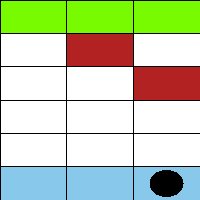

In [191]:
env = gameEnv(200,3)
env.drawGridState()
#env.enemyTurn()
env.canvas

Note:  bots start at 0
Please select a bot (Will request again if less than 0 or greater then number of bots)2
Note:  actions up[0], down[1], pass_left[2], pass_right[3]
Please select an action (will request again if less than 0 or greater then number of actions)0
True


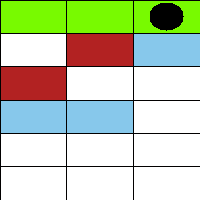

In [204]:
env.playerTurn()
env.enemyTurnRandom()
env.drawGridState()
env.getReward()
print(env.game_over)
env.canvas

In [165]:
env.ball_coor

(1, 5)

In [155]:
l = env.getReward()
print(l)
env.game_over

0


False

Note:  bots start at 0
Please select a bot (Will request again if less than 0 or greater then number of bots)1
Note:  actions up[0], down[1], pass_left[2], pass_right[3], shoot[4]
Please select an action (will request again if less than 0 or greater then number of actions)0
False     False     False     

False     False     False     

False     False     False     

False     False     False     

True      False     False     

False     False     False     



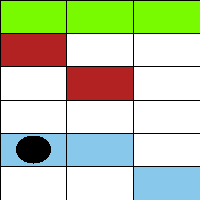

In [146]:
env.playerTurn()
env.printGridState()
env.drawGridState()
env.canvas

In [ ]:
image_size=400
grid_size=5

buffer=image_size/grid_size

In [ ]:
for l in range(grid_size - 1):
    draw.line([((l+1) * buffer,0),((l+1) * buffer),image_size],fill=0)
    draw.line([(0,(l+1) * buffer),(image_size,(l+1) * buffer)],fill=0)

In [ ]:
player = gameObj("Player",(0,0),None)
grid = np.array((grid_size, grid_size), dtype=gameObj)

In [ ]:
#user_bots=4
#enemy_bots = user_bots-1
user_bots=3
grid_length = (user_bots*2)
grid_width = user_bots

In [ ]:
#This sets the object grid, which contains the name, coordinates,and reward of each game object (enemy, player, goal, or space)
object_grid=[[gameObj("Space",[j,i],0,False) for j in range(grid_width)] for i in range(grid_length)]
#For iterating through for loop, the [][] and gameObj(coor) should be reversed. For loop is row, col, coor is x,y
#Fill in the goal which is always placed on the top row
for i in range(grid_width):
    object_grid[0][i]=gameObj("Goal",(i,0),1,False)
#Fill grid with enemies, switch variable used for randomness in spawning of enemies
switch=random.randint(0,1)
for i in range(grid_width-1):
    object_grid[i+1][i+switch]=gameObj("Enemy",(i+switch,i+1),-1,False)
#Setting up player, using random number to decide who has the ball
receive_ball=random.randint(0,grid_width-1)
has_ball=False
for i in range(grid_width):
    if i == receive_ball:
        has_ball=True
    object_grid[grid_length-1][i]=gameObj("Player",(i,grid_length-1),0,has_ball)
    has_ball=False


In [ ]:
row=""
for i in range(grid_length):
    for s in object_grid[i]:
        row=row+ '{:10}'.format(s.has_ball)
    print(row)
    print("")
    row=""